# Part 7. DEAP Dataset + CNN1D_LSTM

In this part 7, we shall try to improve the previous part by adding CNN1D before taking LSTM, since CNN1D helps us smoothen the signal.  Consequently, these signals are much smaller in sequence length thus can drastically increase the speed of training. (it is like taking moving average, instead of using raw data).   Also, since these convoluted signals are not only a single point of samples, inputting into LSTM will lead to much greater accuracies.

**Note**: Also we will be doing some refactoring, and move some of the repeating components into python file, so that it is easier to manage and do not clutter our notebooks.   All python files are kept in the <code>components</code> folder.

*Note that we will be only predicting the valence.  Feel free to work on the arousal yourself.*

In this part, most of the code will be the same except 2 Defining Model.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# setting seed so that splitting process and training process can be reproduce
torch.manual_seed(1)

import numpy as np

#refactoring components
#maybe you want to take a look at these components, because we will be using them in the future series
from components.dataset import Dataset
from components.helper import getLoaders, count_parameters, plot_performance
from components.train import train, evaluate, initialize_weights

Set cuda accordingly.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


## 1. Loading dataset

Let's first reuse the dataset loader we have created in Part 1.

In [3]:
path = "data"  #create a folder "data", and inside put s01.dat,....,s32.dat inside from the preprocessed folder from the DEAP dataset

In [4]:
dataset = Dataset(path, "Valence")

data  = dataset[:]['data']
label = dataset[:]['label']

print("Data shape: " , data.shape)  #15360 = 32 * 40 trials * 12 segments, 32 EEG channels, 672 samples
print("Label shape: ", label.shape)  #two classes of valence

Data shape:  torch.Size([15360, 32, 672])
Label shape:  torch.Size([15360, 1])


## 2. Defining the Model -> CNN1D_LSTM

By applying CNN1D before LSTM, we are smoothening and downsampling the signals. Performing Conv1d can be easily done by using <code>nn.Conv1d</code>.

Let's first look at how cnn1d process our mockdata.

### I. Understanding CNN1D

In [5]:
mock_batch_size = 2    #in real training, we use 32
mock_input_dim  = 32   #in real data, ours is 32 channels
mock_seq_len    = 10   #in real data, ours is 8064

#note that conv1d wants shape of (batch size, channel, seq len), unlike LSTM which wants (batch size, seq len, channel)
mock_eegdata = torch.rand(mock_batch_size, mock_input_dim, mock_seq_len).to(device)

#define the layer
conv1d = nn.Conv1d(mock_input_dim, mock_input_dim, kernel_size=3, stride=1).to(device)

#execute
conv_mock_eegdata = conv1d(mock_eegdata)

print(conv_mock_eegdata.shape)

torch.Size([2, 32, 8])


As we can see, conv1d runs a window along each channel independently, where the window size is defined by the kernel size.  Imagine a block of 10 (i.e., seq_len=10), we define a window size of 3 that shift to the right one block at a time.  This process of convolution will give us a total of 8 values, thus the out_channel would become 8 after the convolution process.  (I recommend you to try draw it out).

**Padding**: Since some block are not being used equally, we can also add padding to the left and right of this ten block by 1, such convolution will create out_channel to 10 after the convolution process

In [6]:
#adding padding = 1 which adds a empty block on the left and right.
conv1d = nn.Conv1d(mock_input_dim, mock_input_dim, kernel_size=3, stride=1, padding=1).to(device)
conv_mock_eegdata = conv1d(mock_eegdata)
print(conv_mock_eegdata.shape)

torch.Size([2, 32, 10])


**Stacking**: There is still one problem, i.e., if we use only kernel size of 3, only three nearby blocks will have some type of interactions.  To model longer-term dependencies, it is also possible to stack convolution layers, so to create some kind of interactions between block1 and farther blocks like block 8.  If you don't see why stacking allows longer-term dependencies, imagine drawing a tree of convolutions.

In [7]:
conv1d = nn.Conv1d(mock_input_dim, mock_input_dim, kernel_size=3, stride=1, padding=1).to(device)

#defining three layers of convolution
conv_mock_eegdata = conv1d(mock_eegdata)
conv_mock_eegdata = conv1d(conv_mock_eegdata)

print(conv_mock_eegdata.shape)

torch.Size([2, 32, 10])


**Batch norm**: Always recommended to add normalization after convolution and before activation

In [8]:
#define a norm layer with param as the input channel
norm = nn.BatchNorm1d(mock_input_dim).to(device)

conv1d = nn.Conv1d(mock_input_dim, mock_input_dim, kernel_size=3, stride=1, padding=1).to(device)

#adding normalization
conv_mock_eegdata = norm(conv1d(mock_eegdata))
conv_mock_eegdata = norm(conv1d(conv_mock_eegdata))
     
print(conv_mock_eegdata.shape)

torch.Size([2, 32, 10])


**Activations**: Add some activation to add some non-linearities

In [9]:
#define a norm layer with param as the input channel
norm = nn.BatchNorm1d(mock_input_dim).to(device)

conv1d = nn.Conv1d(mock_input_dim, mock_input_dim, kernel_size=3, stride=1, padding=1).to(device)

#adding normalization
conv_mock_eegdata = F.relu(norm(conv1d(mock_eegdata)))
conv_mock_eegdata = F.relu(norm(conv1d(conv_mock_eegdata)))
     
print(conv_mock_eegdata.shape)

torch.Size([2, 32, 10])


**Pooling**: Last, to smoothen out noise and obtain a simpler representations, we can use maxpooling, which takes the peak of each window.

In [10]:
#define a norm layer with param as the input channel
norm = nn.BatchNorm1d(mock_input_dim).to(device)

conv1d = nn.Conv1d(mock_input_dim, mock_input_dim, kernel_size=3, stride=1, padding=1).to(device)

#adding pooling
conv_mock_eegdata = F.max_pool1d(F.relu(norm(conv1d(mock_eegdata))), kernel_size=3)
                                     
print(conv_mock_eegdata.shape)  #takes every three blocks and max.  Thus from 10, it becomes 3, ignoring the last block.

torch.Size([2, 32, 3])


### II. Let's define the model

In [11]:
class Conv1D_LSTM(nn.Module):
    '''
    Expected Input Shape: (batch, channels, seq_len)  <==what conv1d wants
    '''
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, bidirectional, dropout):
        super(Conv1D_LSTM, self).__init__()
        self.conv1d = nn.Conv1d(input_dim, input_dim, kernel_size=128, stride=1, padding=1)
        self.norm = nn.BatchNorm1d(input_dim)
        self.lstm = nn.LSTM(input_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * num_layers, output_dim)
        
    def forward(self, x):
        # conv1d expects (batch, channels, seq_len)
        # should not try too big a kernel size, which could lead to too much information loss
        x = F.max_pool1d(F.relu(self.norm(self.conv1d(x))), kernel_size=3)
        x = F.max_pool1d(F.relu(self.norm(self.conv1d(x))), kernel_size=3)

        # change to (batch, seq_len, channels) because lstm expects
        x = x.permute(0,2,1)
        
        #x = [batch size, seq len, channels]
        out, (hn, cn) = self.lstm(x)
        
        #out = [batch size, seq len, hidden dim * num directions]        
        #hn = [num layers * num directions, batch size, hidden dim]
        #cn = [num layers * num directions, batch size, hidden dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

**Model init**: Let's init the class instance and create a workabout model.

In [12]:
#note that these params are simply obtained from trial and error; I got no theory to back up why I use certain numbers here...
input_dim     = 32 #we got 32 EEG channels
hidden_dim    = 256 #let's define hidden dim as 256
num_layers    = 2  #we gonna have two LSTM layers
output_dim    = 1  #we got 4 classes for our labels
bidirectional = True  #uses bidirectional LSTM
dropout       = 0.5  #setting dropout to 0.5

#define the model
model = Conv1D_LSTM(input_dim, hidden_dim, num_layers, output_dim, bidirectional, dropout)

#send to cuda so we can use the GPU
model = model.to(device)  

#apply weights
model.apply(initialize_weights)

Conv1D_LSTM(
  (conv1d): Conv1d(32, 32, kernel_size=(128,), stride=(1,), padding=(1,))
  (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(32, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

**Param count**: Let's also check the number of parameters used

In [13]:
print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model Conv1D_LSTM has 2,302,561 trainable parameters


**Unit test**: Let's define a simple unit test, inputing some mock EEG data and see whether we got the desired output as 4 classes.

In [14]:
mock_batch_size = 2    #in real training, we use 32
mock_input_dim  = 32   #in real data, ours is 32 channels
mock_seq_len    = 8064 #in real data, ours is 8064

#note that our model first layer is conv1d which expects (batch, channel, seq len)
mock_eegdata = torch.rand(mock_batch_size, mock_input_dim, mock_seq_len).to(device)

#let's try run the model by simply inserting the mockdata into the model; very similar to .fit
predictions = model(mock_eegdata)

#let's try to see the predictions whether it really outputs 2 unique classes - 0 and 1
print("Prediction shape: ", predictions.shape)
print("Predictions: ", predictions)

#simple unit test
assert predictions.shape[0] == mock_batch_size
assert predictions.shape[1] == output_dim

Prediction shape:  torch.Size([2, 1])
Predictions:  tensor([[-0.0144],
        [ 0.0184]], device='cuda:0', grad_fn=<AddmmBackward>)


## 3. Training

### I. Batch Iterators

To make it easier to manage, I have put this into our <code>components/helper.py</code>.

In [15]:
train_loader, val_loader, test_loader = getLoaders(dataset=dataset, batch_size=16)

Full Dataset size:  15360
Train Dataset size: 10752
Valid Dataset size: 3072
Test Dataset size:  1536



### II. Optimizers

Optimizer simply refers to the one that gonna take care of the backpropagation process.  The commonly used optimizer is SGD and Adam, both are quite interchangeable.  Here we gonna use Adam.  In order to backpropagate, we gonna define a loss function using cross entropy loss, which is a common loss function for multi-class purposes.

In [16]:
import torch.optim as optim

num_epochs = 50

lr = 0.0001

#can also try SGD which should not make too much of a difference
optimizer = optim.Adam(model.parameters(), lr=lr) 

#combine sigmoid with binary entropy; binary entropy is used for binary classification
criterion = nn.BCEWithLogitsLoss() 

### III. Let's train!

Nothing much but simply run the training functions!

In [17]:
model_saved_name = "models/DEAP_CNN_BiLSTM.pt"

#trainer(num_epochs, model, train_loader, val_loader, optimizer, criterion, model_name, device, seq_len_first=False)
train_losses, valid_losses, train_accs, valid_accs = train(num_epochs, model, train_loader, val_loader, optimizer, criterion, model_saved_name, device)

Epoch: 01 | Epoch Time: 0m 9s
	 Train Loss: 0.674 | Train Acc: 57.65%
	 Val. Loss: 0.686  |  Val. Acc: 57.62%
Epoch: 02 | Epoch Time: 0m 7s
	 Train Loss: 0.414 | Train Acc: 79.88%
	 Val. Loss: 0.648  |  Val. Acc: 62.79%
Epoch: 03 | Epoch Time: 0m 7s
	 Train Loss: 0.136 | Train Acc: 94.75%
	 Val. Loss: 0.578  |  Val. Acc: 82.39%
Epoch: 04 | Epoch Time: 0m 9s
	 Train Loss: 0.046 | Train Acc: 98.44%
	 Val. Loss: 0.577  |  Val. Acc: 86.59%
Epoch: 05 | Epoch Time: 0m 6s
	 Train Loss: 0.033 | Train Acc: 99.00%
	 Val. Loss: 0.560  |  Val. Acc: 83.14%
Epoch: 06 | Epoch Time: 0m 7s
	 Train Loss: 0.019 | Train Acc: 99.46%
	 Val. Loss: 0.555  |  Val. Acc: 88.41%
Epoch: 07 | Epoch Time: 0m 8s
	 Train Loss: 0.025 | Train Acc: 99.18%
	 Val. Loss: 0.559  |  Val. Acc: 86.23%
Epoch: 08 | Epoch Time: 0m 8s
	 Train Loss: 0.024 | Train Acc: 99.14%
	 Val. Loss: 0.563  |  Val. Acc: 73.54%
Epoch: 09 | Epoch Time: 0m 7s
	 Train Loss: 0.019 | Train Acc: 99.32%
	 Val. Loss: 0.509  |  Val. Acc: 86.91%
Epoch: 10 

Let's plot the losses and acc for easier inspection

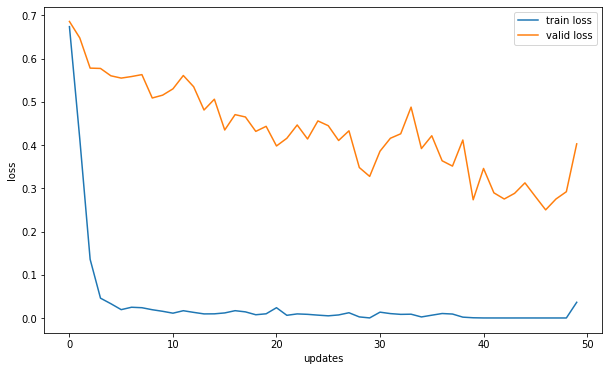

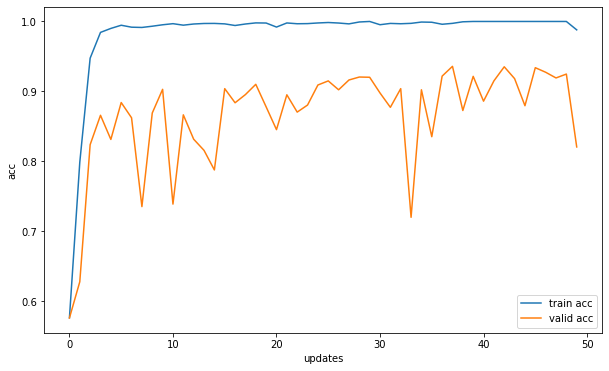

In [18]:
plot_performance(train_losses, valid_losses, "loss")
plot_performance(train_accs, valid_accs, "acc")

## 4. Evaluation on test set

In [19]:
model.load_state_dict(torch.load(model_saved_name))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.254 | Test Acc: 92.45%


## Final Verdict



There are two observations.  

- By performing pooling, it's almost 10 times faster!  That's because LSTM is a very slow model especially if the seq len is very big.  By doing pooling, it downsizes the seq len by almost 10 times, thus the time is also increase dramatically.

- Our accuracy also increases by a lot!  It is clearly because convoluted signals carry more meanings sequentially, thus LSTM was able to learn the patterns.

In the next tutorial, let's try applying attention mechanisms after CNN1D_LSTM, which might help improve accuracy.  I haven't try, so let's see.